In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
car_df = pd.read_excel("./Data/train.xlsx")

In [3]:
#id is not useful
car_df.drop(columns=["id", "clean_title"], inplace=True)
car_df.rename(columns={"milage":"mileage"}, inplace=True)
# the number 2 FOR SOME REASON was found in the transmission column IN A COLUMN OF STRINGS 
car_df["transmission"] = car_df["transmission"].replace(2, "2T")

In [ ]:
car_df.head(4)

,brand,model_year,mileage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000


Heatmap of Correlation of Variables

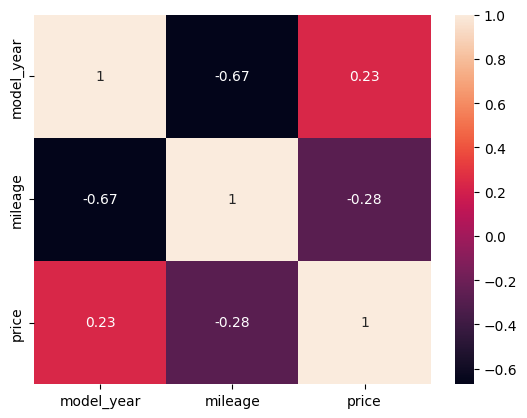

In [4]:
sns.heatmap(car_df.corr(numeric_only=True), annot=True)
plt.show()

Plotting Model Year vs Resale Price

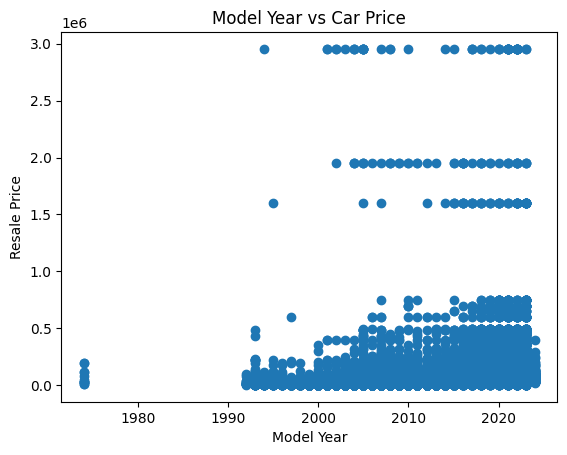

In [5]:
plt.scatter("model_year", "price", data=car_df)
plt.title("Model Year vs Car Price")
plt.xlabel("Model Year")
plt.ylabel("Resale Price")
plt.show()

Plotting Mileage vs Resale Price

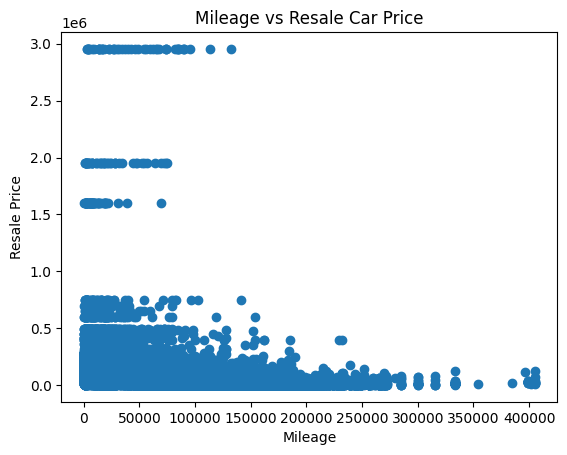

In [ ]:
#plotting mileage vs price
plt.scatter("mileage", "price", data=car_df)
plt.title("Mileage vs Resale Car Price")
plt.xlabel("Mileage")
plt.ylabel("Resale Price")
plt.show()

Obtaining a List of All Categorical and Quantitative Independent Variables

In [6]:
numerical_col = {"model_year", "mileage"}
categorical_col = set(car_df.columns).difference(numerical_col.union({"price"}))
numerical_col = list(numerical_col)
categorical_col = list(categorical_col)

Checking for MultiCollinearity

In [ ]:
#model_year and mileage having correlation ~ 0.7 is worrying, thus I will calculate VIF
def vif_display():
    quant_lst = list(numerical_col.union({"price"}))
    car_vif_df = car_df[quant_lst]
    vif_df = pd.DataFrame({"feature":car_vif_df.columns})
    vif_df["VIF"] = [variance_inflation_factor(car_vif_df.values, i) for
                      i in range(len(car_vif_df.columns))]
    print(vif_df)

vif_display()

      feature       VIF
0     mileage  2.963466
1       price  1.424341
2  model_year  3.664151


Dealing with Missing Values

In [ ]:
#list of all columns with missing values
def fill_wt_mode(df: pd.DataFrame) -> pd.DataFrame:
    cols_wt_na = ["fuel_type", "accident"]
    replace_dict = {}
    #calculating the mode for each column with missing values (they are all categorical variables)
    for col in cols_wt_na:
        replace_dict[col] = df[col].agg(pd.Series.mode).iloc[0]
    #replacing the empty values in each column with the most frequently occuring option
    return df.fillna(value=replace_dict)

#U can use SimpleImputer next time

car_df = fill_wt_mode(car_df)

Dealing With Too Many values In Categorical Columns

In [14]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   mileage       188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 17.3+ MB


In [8]:
car_df[categorical_col].describe()

,model,clean_title,accident,transmission,ext_col,fuel_type,brand,engine,int_col
count,188533,167114,186081,188533,188533,183450,188533,188533,188533
unique,1897,1,2,52,319,7,57,1117,156
top,F-150 XLT,Yes,None reported,A/T,Black,Gasoline,Ford,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,Black
freq,2945,167114,144514,49904,48658,165940,23088,3462,107674


In [22]:

"""
model, ext_col, int_col and engine columns have too many unique values
I plan to find the top 60 by number of occurences and replace those not in top 60 with other
"""
def get_top_60(col_name: str) -> pd.DataFrame:
    #brand is a column with not too many values so we won't want top 60
    top_df = pd.DataFrame(car_df.groupby(by=[col_name]).count()["brand"]).reset_index()
    top_df.rename(columns={"brand":"count"}, inplace=True)
    top_df = top_df.sort_values(by = "count", ascending=False).iloc[:60, ].reset_index()
    return top_df.drop(columns=["index"])


Replacing Values That Don't Appear Often With 'Others'

In [111]:
#dictionary containing the top 60 most frequently occuring values per column for each column
#with too many values
replace_dict = dict()
#columns that have too many values
replace_col = ["model", "ext_col", "int_col", "engine"]
for col in replace_col:
    replace_dict[col] = get_top_60(col)

In [119]:
#initial dataframe is current cars data
car2 = car_df
for col in replace_col:    
    #joins original data with df containing top 60 most occuring
    #values not in top 60 will be NaN in r{col}
    car2 = car2.merge(right=replace_dict[col], how = "outer", 
                        left_on=col, right_on= col)
    #replaces values not in top 60 most occuring with 'Others'
    car2.loc[pd.isna(car2["count"]), col] = "Others"
    #drops the worthless column
    car2.drop(columns=["count"], inplace=True)

In [121]:

car2.head()

,brand,model,model_year,mileage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Chevrolet,Others,2019,61341,Gasoline,Others,8-Speed Automatic,Others,Black,None reported,Yes,18853
1,Chevrolet,Others,2019,53607,Gasoline,Others,9-Speed Automatic,Others,Black,At least 1 accident or damage reported,Yes,39853
2,Honda,Others,2021,15636,Gasoline,Others,6-Speed Automatic,Others,Black,None reported,NaN,15363
3,Chevrolet,Camaro 1SS,2020,30630,Gasoline,Others,8-Speed Automatic,White,Black,None reported,Yes,39687
4,Kia,Others,2021,1930,Gasoline,Others,Automatic CVT,Others,Black,None reported,NaN,16499
